## Data Cleaning and Feature Engineering on Full Dataset

The purpose of this script is to retrieve the full Sparkify customer interaction log data from S3, clean and engineer features, perform a train-test split, and store the results in the Databricks File System (DBFS). The results will be used to train both PySpark and Scikit-Learn models. The custom PySpark functions used below were iteratively created on the sample dataset and refined using the full dataset in S3. 

**NOTE:** This script was run on Microsoft Azure Databricks using Runtime Version 10.1.

In [0]:
spark

Out[1]:

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.2.0 
 Master 
 spark://10.139.64.4:7077 
 AppName 
 Databricks Shell

In [0]:
%sh
pip install --upgrade mlflow

Requirement already satisfied: mlflow in /databricks/python3/lib/python3.8/site-packages (1.23.1)
Requirement already satisfied: pytz in /databricks/python3/lib/python3.8/site-packages (from mlflow) (2020.5)
Requirement already satisfied: Flask in /databricks/python3/lib/python3.8/site-packages (from mlflow) (2.0.3)
Requirement already satisfied: sqlalchemy in /databricks/python3/lib/python3.8/site-packages (from mlflow) (1.4.31)
Requirement already satisfied: scipy in /databricks/python3/lib/python3.8/site-packages (from mlflow) (1.6.2)
Requirement already satisfied: alembic in /databricks/python3/lib/python3.8/site-packages (from mlflow) (1.7.6)
Requirement already satisfied: pandas in /databricks/python3/lib/python3.8/site-packages (from mlflow) (1.2.4)
Requirement already satisfied: sqlparse>=0.3.1 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (0.4.2)
Requirement already satisfied: gitpython>=2.1.0 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (3.1.27)
Requirement already satisfied: numpy in /databricks/python3/lib/python3.8/site-packages (from mlflow) (1.19.2)
Requirement already satisfied: databricks-cli>=0.8.7 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (0.16.4)
Requirement already satisfied: packaging in /databricks/python3/lib/python3.8/site-packages (from mlflow) (20.9)
Requirement already satisfied: protobuf>=3.7.0 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (3.17.2)
Requirement already satisfied: requests>=2.17.3 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (2.25.1)
Requirement already satisfied: cloudpickle in /databricks/python3/lib/python3.8/site-packages (from mlflow) (2.0.0)
Requirement already satisfied: click>=7.0 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (8.0.4)
Requirement already satisfied: gunicorn in /databricks/python3/lib/python3.8/site-packages (from mlflow) (20.1.0)
Requirement already satisfied: docker>=4.0.0 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (5.0.3)
Requirement already satisfied: querystring-parser in /databricks/python3/lib/python3.8/site-packages (from mlflow) (1.2.4)
Requirement already satisfied: pyyaml>=5.1 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (6.0)
Requirement already satisfied: importlib-metadata!=4.7.0,>=3.7.0 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (4.11.2)
Requirement already satisfied: entrypoints in /databricks/python3/lib/python3.8/site-packages (from mlflow) (0.3)
Requirement already satisfied: prometheus-flask-exporter in /databricks/python3/lib/python3.8/site-packages (from mlflow) (0.18.7)
Requirement already satisfied: six>=1.10.0 in /databricks/python3/lib/python3.8/site-packages (from databricks-cli>=0.8.7->mlflow) (1.15.0)
Requirement already satisfied: tabulate>=0.7.7 in /databricks/python3/lib/python3.8/site-packages (from databricks-cli>=0.8.7->mlflow) (0.8.9)
Requirement already satisfied: websocket-client>=0.32.0 in /databricks/python3/lib/python3.8/site-packages (from docker>=4.0.0->mlflow) (1.3.1)
Requirement already satisfied: gitdb<5,>=4.0.1 in /databricks/python3/lib/python3.8/site-packages (from gitpython>=2.1.0->mlflow) (4.0.9)
Requirement already satisfied: smmap<6,>=3.0.1 in /databricks/python3/lib/python3.8/site-packages (from gitdb<5,>=4.0.1->gitpython>=2.1.0->mlflow) (5.0.0)
Requirement already satisfied: zipp>=0.5 in /databricks/python3/lib/python3.8/site-packages (from importlib-metadata!=4.7.0,>=3.7.0->mlflow) (3.7.0)
Requirement already satisfied: certifi>=2017.4.17 in /databricks/python3/lib/python3.8/site-packages (from requests>=2.17.3->mlflow) (2020.12.5)
Requirement already satisfied: chardet<5,>=3.0.2 in /databricks/python3/lib/python3.8/site-packages (from requests>=2.17.3->mlflow) (4.0.0)
Requirement already satisfied: urllib3<1.27,>=1.21.1 in /databricks/python3/lib/python3.8/site-packages (from requests>=2.17.3->mlflow) (1.25.11)
Requirement a

In [0]:
import sys
#sys.path.append("Workspace/Repos/sparkify/sparkify-customer-retention")
sys.path.append("../src")
from sparkifychurn import cleanData, exploreData, generateFeatures, utils
import mlflow
import pyspark.sql.functions as F
import pandas as pd
pd.set_option("max.columns", None)
pd.set_option("max.rows", None)
import seaborn as sns
sns.set_theme()

## Read in Full Data Set from S3

In [0]:
df = spark.read.json("s3n://udacity-dsnd/sparkify/sparkify_event_data.json").cache()

In [0]:
df.count()

Out[5]: 26259199

In [0]:
df.limit(5).toPandas()

Out[6]:

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Popol Vuh,Logged In,Shlok,M,278,Johnson,524.32934,paid,"Dallas-Fort Worth-Arlington, TX",PUT,NextSong,1533734541000,22683,Ich mache einen Spiegel - Dream Part 4,200,1538352001000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",1749042
1,Los Bunkers,Logged In,Vianney,F,9,Miller,238.39302,paid,"San Francisco-Oakland-Hayward, CA",PUT,NextSong,1537500318000,20836,MiÃÂ©ntele,200,1538352002000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",1563081
2,Lush,Logged In,Vina,F,109,Bailey,140.35546,paid,"Hilo, HI",PUT,NextSong,1536414505000,4593,Baby Talk,200,1538352002000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; r...,1697168
3,Barry Tuckwell/Academy of St Martin-in-the-Fie...,Logged In,Andres,M,71,Foley,277.15873,paid,"Watertown, SD",PUT,NextSong,1534386660000,6370,Horn Concerto No. 4 in E flat K495: II. Romanc...,200,1538352003000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",1222580
4,Yes,Logged In,Aaliyah,F,21,Ramirez,1121.25342,paid,"Baltimore-Columbia-Towson, MD",PUT,NextSong,1537381415000,22316,Close To The Edge (I. The Solid Time Of Change...,200,1538352003000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",1714398


In [0]:
exploreData.summarize_missing_vals(df)

****Feature artist complete.****
****Feature auth complete.****
****Feature firstName complete.****
****Feature gender complete.****
****Feature itemInSession complete.****
****Feature lastName complete.****
****Feature length complete.****
****Feature level complete.****
****Feature location complete.****
****Feature method complete.****
****Feature page complete.****
****Feature registration complete.****
****Feature sessionId complete.****
****Feature song complete.****
****Feature status complete.****
****Feature ts complete.****
****Feature userAgent complete.****
****Feature userId complete.****
Out[7]:

,feature,data_type,missing_count,missing_percentage,empty_string_count,empty_percentage
0,artist,string,5408927,20.60,0.0,0.0
1,auth,string,0,0.00,0.0,0.0
2,firstName,string,778479,2.96,0.0,0.0
3,gender,string,778479,2.96,0.0,0.0
4,itemInSession,bigint,0,0.00,NaN,NaN
5,lastName,string,778479,2.96,0.0,0.0
6,length,double,5408927,20.60,NaN,NaN
7,level,string,0,0.00,0.0,0.0
8,location,string,778479,2.96,0.0,0.0
9,method,string,0,0.00,0.0,0.0


In [0]:
page_summary = df.groupby("page").count().toPandas()
page_summary = page_summary.sort_values('count', ascending = False)

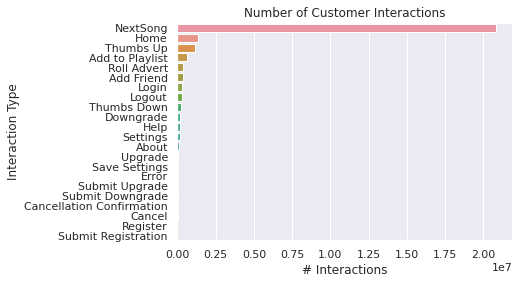

In [0]:
from matplotlib import pyplot as plt 
fig, ax = plt.subplots()
sns.barplot(x='count', y='page', data = page_summary, ax = ax)
ax.set_xlabel("# Interactions")
ax.set_ylabel("Interaction Type")
ax.set_title("Number of Customer Interactions");

## Clean Data

In [0]:
df_clean = cleanData.clean_logs(df)

In [0]:
exploreData.summarize_missing_vals(df_clean)

****Feature artist complete.****
****Feature auth complete.****
****Feature firstName complete.****
****Feature gender complete.****
****Feature itemInSession complete.****
****Feature lastName complete.****
****Feature length complete.****
****Feature level complete.****
****Feature location complete.****
****Feature method complete.****
****Feature page complete.****
****Feature registration complete.****
****Feature sessionId complete.****
****Feature song complete.****
****Feature status complete.****
****Feature ts complete.****
****Feature userAgent complete.****
****Feature userId complete.****
Out[30]:

,feature,data_type,missing_count,missing_percentage,empty_string_count,empty_percentage
0,artist,string,5408927,20.60,0.0,0.0
1,auth,string,0,0.00,0.0,0.0
2,firstName,string,778479,2.96,0.0,0.0
3,gender,string,778479,2.96,0.0,0.0
4,itemInSession,bigint,0,0.00,NaN,NaN
5,lastName,string,778479,2.96,0.0,0.0
6,length,double,0,0.00,NaN,NaN
7,level,string,0,0.00,0.0,0.0
8,location,string,778479,2.96,0.0,0.0
9,method,string,0,0.00,0.0,0.0


## Perform Feature Engineering

In [0]:
user_summary = generateFeatures.generate_features(df_clean)

In [0]:
user_summary.limit(5).toPandas()

Out[27]:

,userId,gender,count_items,sum_length,paid,session_count,submit_downgrade_count,thumbs_down_count,home_count,downgrade_count,advert_count,save_settings_count,churn,about_count,settings_count,add_playlist_count,add_friend_count,next_song_count,thumbs_up_count,help_count,upgrade_count,error_count,submit_upgrade,non_song_interaction_count,PUT_200_count,GET_200_count,PUT_307_count,tenure_days,thumbs_up_pct,avg_items_session,avg_songs_session,sum_session_length_hours,avg_session_length_hours,interaction_rate,submit_downgrade_rate,thumbs_down_rate,home_rate,downgrade_rate,advert_rate,save_settings_rate,about_rate,settings_rate,add_playlist_rate,add_friend_rate,next_song_rate,thumbs_up_rate,help_rate,upgrade_rate,error_rate,non_song_interaction_rate
0,1000280,M,1317,259349.89726,1,22,1,33,44,3,74,1,1,0,9,25,14,1022,53,8,9,3,1,294,1047,148,119,43.075775,0.616279,59.863636,46.454545,71.465556,3.248434,18.428458,0.013993,0.461761,0.615681,0.041978,1.035464,0.013993,0.0,0.125935,0.349819,0.195899,14.300595,0.741616,0.111942,0.125935,0.041978,4.113870
1,1000353,F,299,58037.12912,1,4,0,4,12,7,0,1,1,0,1,4,9,239,13,2,0,0,0,59,243,23,33,21.933322,0.764706,74.750000,59.750000,16.814722,4.203681,17.782036,0.000000,0.237887,0.713660,0.416302,0.000000,0.059472,0.0,0.059472,0.237887,0.535245,14.213735,0.773132,0.118943,0.000000,0.000000,3.508830
2,1000503,F,219,47064.99093,1,3,0,3,5,5,0,0,1,0,1,2,3,191,3,2,0,0,0,27,193,14,12,10.153935,0.500000,73.000000,63.666667,12.847222,4.282407,17.046486,0.000000,0.233514,0.389189,0.389189,0.000000,0.000000,0.0,0.077838,0.155676,0.233514,14.867027,0.233514,0.155676,0.000000,0.000000,2.101622
3,1000675,F,372,63950.72460,0,9,0,9,19,0,45,1,1,0,3,6,9,249,14,2,5,0,0,122,255,75,42,31.166771,0.608696,41.333333,27.666667,17.277222,1.919691,21.531239,0.000000,0.520917,1.099714,0.000000,2.604585,0.057880,0.0,0.173639,0.347278,0.520917,14.412039,0.810315,0.115759,0.289398,0.000000,7.061320
4,1000804,M,249,46455.63170,0,5,0,9,10,0,13,0,1,0,0,3,1,193,12,1,1,0,0,55,196,26,27,20.056609,0.571429,49.800000,38.600000,12.614444,2.522889,19.739276,0.000000,0.713468,0.792742,0.000000,1.030565,0.000000,0.0,0.000000,0.237823,0.079274,15.299921,0.951290,0.079274,0.079274,0.000000,4.360081


In [0]:
exploreData.summarize_missing_vals(user_summary)

****Feature userId complete.****
****Feature gender complete.****
****Feature count_items complete.****
****Feature sum_length complete.****
****Feature paid complete.****
****Feature session_count complete.****
****Feature submit_downgrade_count complete.****
****Feature thumbs_down_count complete.****
****Feature home_count complete.****
****Feature downgrade_count complete.****
****Feature advert_count complete.****
****Feature save_settings_count complete.****
****Feature churn complete.****
****Feature about_count complete.****
****Feature settings_count complete.****
****Feature add_playlist_count complete.****
****Feature add_friend_count complete.****
****Feature next_song_count complete.****
****Feature thumbs_up_count complete.****
****Feature help_count complete.****
****Feature upgrade_count complete.****
****Feature error_count complete.****
****Feature submit_upgrade complete.****
****Feature non_song_interaction_count complete.****
****Feature PUT_200_count complete.****
****Feature GET_200_count complete.****
****Feature PUT_307_count complete.****
****Feature tenure_days complete.****
****Feature thumbs_up_pct complete.****
****Feature avg_items_session complete.****
****Feature avg_songs_session complete.****
****Feature sum_session_length_hours complete.****
****Feature avg_session_length_hours complete.****
****Feature interaction_rate complete.****
****Feature submit_downgrade_rate complete.****
****Feature thumbs_down_rate complete.****
****Feature home_rate complete.****
****Feature downgrade_rate complete.****
****Feature advert_rate complete.****
****Feature save_settings_rate complete.****
****Feature about_rate complete.****
****Feature settings_rate complete.****
****Feature add_playlist_rate complete.****
****Feature add_friend_rate complete.****
****Feature next_song_rate complete.****
****Feature thumbs_up_rate complete.****
****Feature help_rate complete.****
****Feature upgrade_rate complete.****
****Feature error_rate complete.****
****Feature non_song_interaction_rate complete.****
Out[28]:

,feature,data_type,missing_count,missing_percentage,empty_string_count,empty_percentage
0,userId,string,0,0.0,0.0,0.0
1,gender,string,1,0.0,0.0,0.0
2,count_items,bigint,0,0.0,NaN,NaN
3,sum_length,double,0,0.0,NaN,NaN
4,paid,int,0,0.0,NaN,NaN
5,session_count,bigint,0,0.0,NaN,NaN
6,submit_downgrade_count,bigint,0,0.0,NaN,NaN
7,thumbs_down_count,bigint,0,0.0,NaN,NaN
8,home_count,bigint,0,0.0,NaN,NaN
9,downgrade_count,bigint,0,0.0,NaN,NaN


In [0]:
user_summary.groupby("churn").count().show()

+-----+-----+
churn|count|
+-----+-----+
 1| 5003|
 0|17275|
+-----+-----+

In [0]:
user_summary.describe().toPandas()

Out[33]:

,summary,userId,gender,count_items,sum_length,paid,session_count,submit_downgrade_count,thumbs_down_count,home_count,downgrade_count,advert_count,save_settings_count,churn,about_count,settings_count,add_playlist_count,add_friend_count,next_song_count,thumbs_up_count,help_count,upgrade_count,error_count,submit_upgrade,non_song_interaction_count,PUT_200_count,GET_200_count,PUT_307_count,tenure_days,thumbs_up_pct,avg_items_session,avg_songs_session,sum_session_length_hours,avg_session_length_hours,interaction_rate,submit_downgrade_rate,thumbs_down_rate,home_rate,downgrade_rate,advert_rate,save_settings_rate,about_rate,settings_rate,add_playlist_rate,add_friend_rate,next_song_rate,thumbs_up_rate,help_rate,upgrade_rate,error_rate,non_song_interaction_rate
0,count,22278,22277,22278,22278,22278,22278,22278,22278,22278,22278,22278,22278,22278,22278,22278,22278,22278,22278,22278,22278,22278,22278,22278,22278,22278,22278,22278,22278,22278,22278,22278,22278,22278,22278,22278,22278,22278,22278,22278,22278,22278,22278,22278,22278,22278,22278,22278,22278,22278,22278
1,mean,1498782.9615764432,None,1178.7054044348686,232785.3905507565,0.7265014812819822,20.431726366819284,0.2914983391686866,10.73758865248227,60.28826645120747,8.270042194092827,17.29113924050633,1.3248945147679325,0.22457132597181076,4.1637041027022175,6.601759583445552,26.839078911931054,17.131878983750784,935.9130981237095,51.686192656432354,6.962025316455696,2.2671245174611725,1.1653649340156207,0.5423287548253882,242.56773498518717,962.7521770356406,106.1046323727444,108.68323009246791,40.96370727494823,0.7943606750286493,80.79635411875446,65.52397855078138,710.6973919086453,4.60896293389017,20.350586499384285,0.004629769751619402,0.18807308141108847,1.214390965952657,0.1028171266273346,0.6255576727521484,0.023806783858560363,0.04369718513709696,0.11997266916515668,0.4055324202869168,0.28815610219634674,15.128824257093797,0.7837477975184576,0.0928406843467582,0.06787854573524425,0.018785847511152164,5.173765156435251
2,stddev,288851.8472659194,None,5372.959939882253,273530.67950925673,0.44576450998183387,1059.3297847404115,0.6058552928524243,12.615942418588649,2746.8741713756076,11.60028308224029,20.63891885576954,1.8846811059745325,0.4173090731235617,297.350417699249,7.867685290670085,32.071277914640696,20.51493208297262,1099.625399285085,64.58884961218529,171.97304103445012,2.652989041626245,6.33809302889638,0.49821623661074427,5219.06619371127,1131.2682903409172,3221.9004191134986,1990.5875914351534,18.8848911256823,0.17307444390083893,48.56787516595491,41.38415630401575,96282.27504278436,3.011352886986769,122.1486127069609,0.016832450019645517,0.2537053185392944,34.790290963014314,0.30785429754940713,2.179539751679833,0.10795317676444773,1.047830425324194,0.7118376068707893,0.19976392374194782,1.542484868004935,48.52433581893563,0.4272426968726099,0.14853145493803693,0.12817704152575665,0.05722036896143289,81.16108782495216
3,min,1000025,F,1,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,max,1999996,M,778479,2807182.33115,1,158115,7,154,409978,133,269,24,1,44382,80,340,222,11314,836,25652,29,914,1,778479,11654,480814,296751,60.999780092592594,1.0,693.0,579.0,1.4370976770274183E7,90.889395505007,10800.0,1.2671594508975712,20.454545454545453,3600.0,41.860465116279066,200.0,12.99638989169675,150.0,101.40845070422536,6.282722513089005,194.59459459459458,3600.0,26.865671641791046,15.584415584415586,5.797101449275363,3.6253776435045317,7200.0


## Perform Train/Test Split

In [0]:
train, test = utils.train_test_stratified_split(user_summary, "churn", [.7, .3], 1234)

# Coalescing and caching dataframe due to relatively small number of userIds
train = train.coalesce(1).cache()
test = test.coalesce(1).cache()

In [0]:
train.printSchema()

root
-- userId: string (nullable = true)
-- gender: string (nullable = true)
-- count_items: long (nullable = false)
-- sum_length: double (nullable = false)
-- paid: integer (nullable = true)
-- session_count: long (nullable = false)
-- submit_downgrade_count: long (nullable = true)
-- thumbs_down_count: long (nullable = true)
-- home_count: long (nullable = true)
-- downgrade_count: long (nullable = true)
-- advert_count: long (nullable = true)
-- save_settings_count: long (nullable = true)
-- churn: integer (nullable = true)
-- about_count: long (nullable = true)
-- settings_count: long (nullable = true)
-- add_playlist_count: long (nullable = true)
-- add_friend_count: long (nullable = true)
-- next_song_count: long (nullable = true)
-- thumbs_up_count: long (nullable = true)
-- help_count: long (nullable = true)
-- upgrade_count: long (nullable = true)
-- error_count: long (nullable = true)
-- submit_upgrade: integer (nullable = true)
-- non_song_interaction_count: long (nullable = true)
-- PUT_200_count: long (nullable = true)
-- GET_200_count: long (nullable = true)
-- PUT_307_count: long (nullable = true)
-- tenure_days: double (nullable = false)
-- thumbs_up_pct: double (nullable = false)
-- avg_items_session: double (nullable = false)
-- avg_songs_session: double (nullable = false)
-- sum_session_length_hours: double (nullable = false)
-- avg_session_length_hours: double (nullable = false)
-- interaction_rate: double (nullable = false)
-- submit_downgrade_rate: double (nullable = false)
-- thumbs_down_rate: double (nullable = false)
-- home_rate: double (nullable = false)
-- downgrade_rate: double (nullable = false)
-- advert_rate: double (nullable = false)
-- save_settings_rate: double (nullable = false)
-- about_rate: double (nullable = false)
-- settings_rate: double (nullable = false)
-- add_playlist_rate: double (nullable = false)
-- add_friend_rate: double (nullable = false)
-- next_song_rate: double (nullable = false)
-- thumbs_up_rate: double (nullable = false)
-- help_rate: double (nullable = false)
-- upgrade_rate: double (nullable = false)
-- error_rate: double (nullable = false)
-- non_song_interaction_rate: double (nullable = false)

In [0]:
print("Train Size: ({},{})".format(train.count(),len(train.columns)))
print("Test Size: ({},{})".format(test.count(),len(test.columns)))

Train Size: (15438,50)
Test Size: (6840,50)

## Save Train and Test Datasets in DBFS

In [0]:
%fs ls FileStore

In [0]:
%fs mkdirs /FileStore/data/

res10: Boolean = true

In [0]:
train.write.mode("overwrite").parquet("dbfs:/FileStore/data/train_full")
test.write.mode("overwrite").parquet("dbfs:/FileStore/data/test_full")

In [0]:
%fs ls /FileStore/data

path,name,size
dbfs:/FileStore/data/test_full/,test_full/,0
dbfs:/FileStore/data/train_full/,train_full/,0


In [0]:
%fs ls lr_model

path,name,size
dbfs:/lr_model/bestModel/,bestModel/,0
dbfs:/lr_model/estimator/,estimator/,0
dbfs:/lr_model/evaluator/,evaluator/,0
dbfs:/lr_model/metadata/,metadata/,0


## Data Exploration on Train Data

In [0]:
train.groupby("churn").agg(F.mean("sum_length"), 
                                  F.mean("tenure_days"),
                                  F.mean("thumbs_down_rate"), 
                                  F.mean("interaction_rate"), 
                                  F.mean("avg_session_length_hours"),
                                  F.mean("thumbs_up_pct"),
                                  F.mean("error_rate"), 
                                  F.mean("advert_rate"),
                                  F.mean("downgrade_rate"), 
                                  F.mean("avg_songs_session"),
                                  F.mean("non_song_interaction_rate")).toPandas()

Out[37]:

,churn,avg(sum_length),avg(tenure_days),avg(thumbs_down_rate),avg(interaction_rate),avg(avg_session_length_hours),avg(thumbs_up_pct),avg(error_rate),avg(advert_rate),avg(downgrade_rate),avg(avg_songs_session),avg(non_song_interaction_rate)
0,1,219846.292184,24.493221,0.222765,18.929489,4.778569,0.757697,0.018064,0.840148,0.137870,67.800360,4.281903
1,0,236685.616224,45.817771,0.175333,21.140127,4.555191,0.807356,0.018635,0.560267,0.093229,64.764637,5.749833


In [0]:
train_pd = train.toPandas()

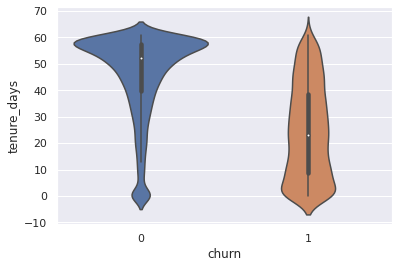

In [0]:
sns.violinplot(x = "churn", y = "tenure_days", data = train_pd);

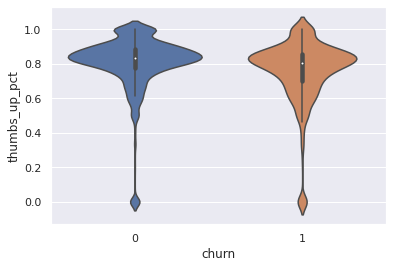

In [0]:
sns.violinplot(x = "churn", y = "thumbs_up_pct", data = train_pd);

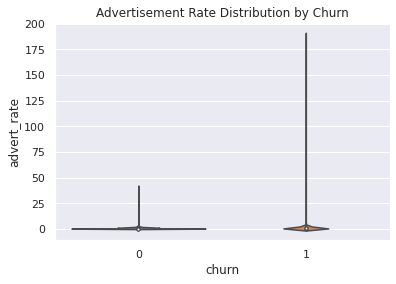

In [0]:
fig, ax = plt.subplots()
sns.violinplot(x = "churn", y = "advert_rate", data = train_pd, ax = ax)
ax.set_title("Advertisement Rate Distribution by Churn");

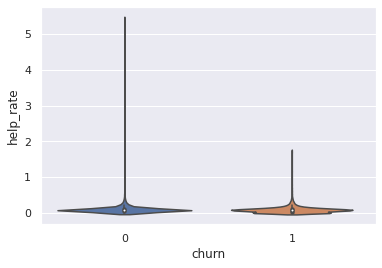

In [0]:
sns.violinplot(x = "churn", y = "help_rate", data = train_pd);